# Deploying Your Model
Now that we have a well trained model, it's time to use it. In this exercise, we'll expose new images to our model and detect the correct letters of the sign language alphabet. Let's get started!

## Objectives

* Load an already-trained model from disk
* Reformat images for a model trained on images of a different format
* Perform inference with new images, never seen by the trained model and evaluate its performance

## Loading the Model
Now that we're in a new notebook, let's load the saved model that we trained. Our save from the previous exercise created a folder called "asl_model". We can load the model by selecting the same folder.

In [1]:
from tensorflow import keras

model = keras.models.load_model('../models/3_sl_augmented_model')

If you'd like to make sure everything looks intact, you can see the summary of the model again.

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

## Preparing an Image for the Model

It's now time to use the model to make predictions on new images that it's never seen before. This is also called inference. We've provided a set of images in the data/asl_images folder.

You'll notice that the images we have are much higher resolution than the images in our dataset. They are also in color. Remember that our images in the dataset were 28x28 pixels and grayscale. It's important to keep in mind that whenever you make predictions with a model, the input must match the shape of the data that the model was trained on. For this model, the training dataset was of the shape: (27455, 28, 28, 1). This corresponded to 27455 images of 28 by 28 pixels each with one color channel (grayscale). 

### Showing the Images

When we use our model to make predictions on new images, it will be useful to show the image as well. We can use the matplotlib library to do this.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

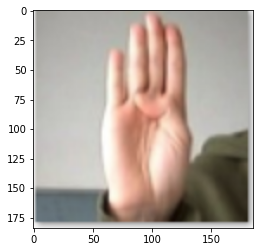

In [4]:
show_image('../data/asl_images/b.png')

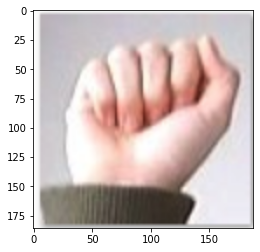

In [5]:
show_image('../data/asl_images/a.png')

### Scaling the Images

The images in our dataset were 28x28 pixels and grayscale. We need to make sure to pass the same size and grayscale images into our method for prediction. There are a few ways to edit images with Python, but Keras has a built-in utility that works well. 

In [6]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(
        image_path,
        color_mode="grayscale",
        target_size=(28,28)
        )
    return image

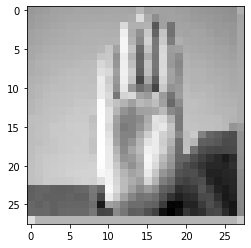

In [7]:
image = load_and_scale_image('../data/asl_images/b.png')
plt.imshow(image, cmap='gray')

### Preparing the Image for Prediction

Now that we have a 28x28 pixel grayscale image, we're close to being ready to pass it into our model for prediction. First we need to reshape our image to match the shape of the dataset the model was trained on. Before we can reshape, we need to convert our image into a more rudimentary format. We'll do this with a keras utility called image_to_array.

In [8]:
image = image_utils.img_to_array(image)

In [9]:
# This reshape corresponds to 1 image of 28x28 pixels with one color channel
image = image.reshape(1,28,28,1) 

Finally, we should remember to normalize our data (making all values between 0-1), as we did with our training dataset:

In [10]:
image = image / 255

## Making Predictions

Okay, now we're ready to predict! This is done by passing our pre-processed image into the model's predict method. 

In [11]:
prediction = model.predict(image)
print(prediction)

[[2.1766820e-27 9.9999475e-01 3.5232441e-31 2.4688201e-34 3.9403609e-21
  5.1900879e-06 5.8128953e-34 9.7042165e-34 3.1476676e-16 6.1262391e-33
  3.5170208e-27 3.2352368e-36 0.0000000e+00 0.0000000e+00 2.5184404e-30
  7.7198696e-33 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.7782909e-30
  0.0000000e+00 2.5291229e-18 6.8358007e-25 5.8103666e-27]]


### Understanding the Prediction

The predictions are in the format of a 24 length array. Though it looks a bit different, this is the same format as our "binarized" categorical arrays from y_train and y_test. Each element of the array is a probability between 0 and 1, representing the confidence for each category. Let's make it a little more readable. We can start by finding which element of the array represents the highest probability. This can be done easily with the numpy library and the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function.

In [12]:
import numpy as np
np.argmax(prediction)

1

Each element of the prediction array represents a possible letter in the sign language alphabet. Remember that j and z are not options because they involve moving the hand, and we're only dealing with still photos. Let's create a mapping between the index of the predictions array, and the corresponding letter. 

In [13]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'k',
 10: 'l',
 11: 'm',
 12: 'n',
 13: 'o',
 14: 'p',
 15: 'q',
 16: 'r',
 17: 's',
 18: 't',
 19: 'u',
 20: 'v',
 21: 'w',
 22: 'x',
 23: 'y'}

We can now pass in our prediction index to find the corresponding letter.

In [14]:
dictionary[np.argmax(prediction)]

'b'

## Put it all Together
Let's put everything in a function so that we can make predictions just from the image file.

In [15]:
def predict_letter(file_path):
    # Show image
    show_image(file_path)
    # Load and scale image
    image = load_and_scale_image(file_path)
    # Convert to array
    image = image_utils.img_to_array(image)
    # Reshape image
    image = image.reshape(1, 28, 28, 1)
    # Normalize image
    image = image / 255
    # Make prediction
    prediction = model.predict(image)
    # Convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    # Return prediction
    return predicted_letter

'b'

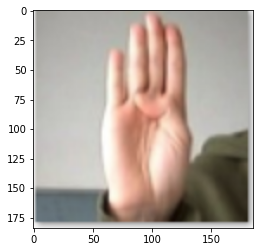

In [16]:
predict_letter("../data/asl_images/b.png")

Let's also use the function with the 'a' letter in the asl_images datset:

'a'

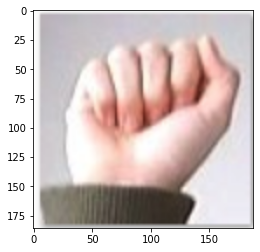

In [17]:
predict_letter("../data/asl_images/a.png")

## Clear the Memory

In [18]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}